# Exercise 3

Name: Adam Dzadon

Student number: 2407741

## Libraries

First, let us import and install all the libraries we are going to use for the exercise.

We are going to use:

*   [PyTorch](https://pytorch.org/) for neural network building blocks and training resources
*   [Pandas](https://pandas.pydata.org/docs/) for pretty table printing
*   [NumPy](https://numpy.org/doc/) for fast numerical computations
*   [Matplotlib](https://matplotlib.org/stable/index.html) for data visualization
*   [tqdm](https://tqdm.github.io/) for progress bar during the training


In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.5 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


## NN architecture

Next, we are going to take our CNN from EX1:

In [9]:
class CNN(nn.Module):
    def __init__(self,
                 in_size: tuple[int, int],
                 in_dim: int,
                 out_classes: int,
                 activation: nn.Module,
                 output_activation) -> None:
        """
        Parameters:
            - in_size          : spatial dimensions of input images
            - in_dim           : number of channels of input images
            - out_classes      : target number of classes
            - activation       : node function used in hidden layers
            - output_actiation : final activation
        """
        super().__init__()

        conv_w = in_size[0] // 8
        conv_h = in_size[1] // 8

        self.network = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(128 * conv_w * conv_h, 64),
            activation(),
            nn.Linear(64, out_classes)
        )

        self.output_activation = output_activation

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.output_activation(self.network(x))

## Data preparation

In this exercise, we work only with MNIST dataset.

In [4]:
def show_images(ims: list[torch.tensor], labels: list[int | str], preds: list[int | str]=None, mnist: bool=True) -> None:
    assert len(ims) == len(labels)

    rows, cols = len(ims) // 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i in range(len(ims)):
        row, col = divmod(i, cols)

        if mnist:
            image_np = (ims[i].permute(1, 2, 0) * 255).to(torch.uint8).numpy()
            axes[row, col].imshow(image_np, cmap='gray')
        else:
            image_np = (((ims[i].permute(1, 2, 0) + 1) / 2) * 255).to(torch.uint8).numpy()
            axes[row, col].imshow(image_np)

        axes[row, col].axis('off')

        desc = "Target: " + str(labels[i]) + "\n" + "Prediction: " + str(preds[i]) if preds is not None else labels[i]
        axes[row, col].set_title(desc, fontsize=12)

We prepare MNIST dataset:

In [5]:
MNIST_train = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

MNIST_test = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.2MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.31MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let us observe some characteristics of our data:

In [6]:
print("Train size:", len(MNIST_train))
print("Test size:", len(MNIST_test))

Train size: 60000
Test size: 10000


Next, we observe the characteristics of the images:

In [7]:
im = MNIST_train[0][0]
print("Dimensions:", im.shape)
MNIST_dims = im.shape[1], im.shape[2]
print("Pixel boundaries:", torch.min(im), torch.max(im))

Dimensions: torch.Size([1, 28, 28])
Pixel boundaries: tensor(0.) tensor(1.)


We observe that the images are grayscale (1 color channel) and have 28x28 pixels. Finally, they are rescaled into [0, 1] interval.

Finally, let us show some images from the dataset:

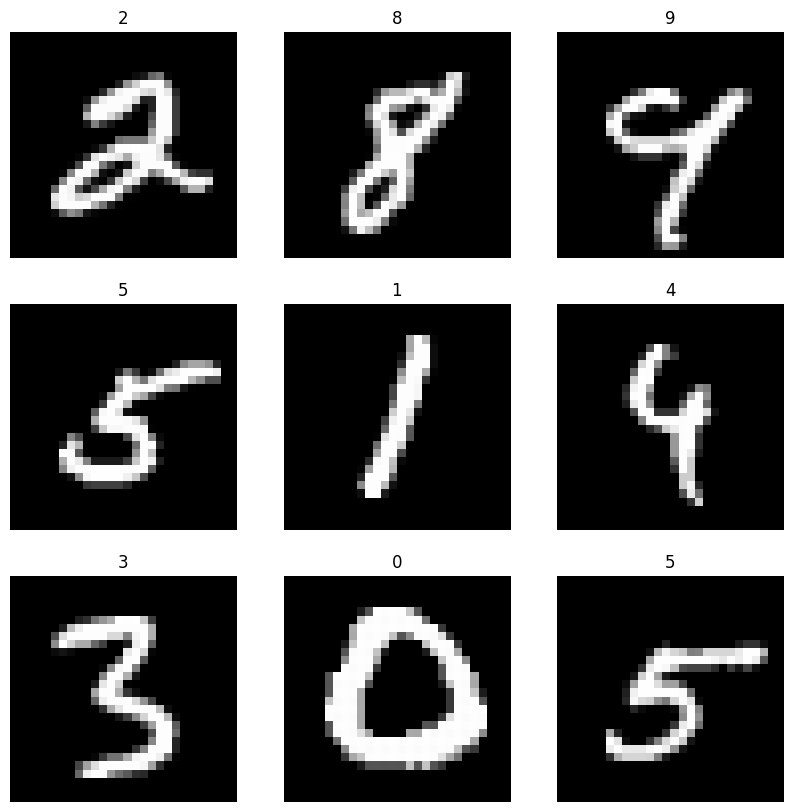

In [8]:
indices = [5, 17, 54, 175, 269, 354, 1588, 5698, 9951]
show_images([MNIST_train[i][0] for i in indices], [MNIST_train[i][1] for i in indices])

## Training

We take the training procedure together with validation after each epoch (from previous exercises):

In [10]:
def train(train_data: DataLoader,
          val_data: DataLoader,
          model: nn.Module,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int) -> tuple[
              list[float], list[float], list[float], list[float]
              ]:
    """
    Parameters:
        - train_data: DataLoader containing training data
        - val_data  : DataLoader containing validation (test) data
        - model     : CNN to be trained
        - loss_fn   : Loss function used
        - optimizer : Object performing weight optimization
        - epochs    : Number of epochs
    """

    # --- Initialize accuracy computing unit
    acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    # ---

    # --- We are going to measure loss and accuracy on train and validation set for each epoch
    train_n_batches = len(train_data)
    val_n_batches = len(val_data)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    # ---

    progress_bar = tqdm(range(epochs), desc=f"Epochs")
    for epoch in progress_bar:

        # --- Training
        epoch_loss = 0
        epoch_acc = 0

        for X_batch, Y_batch in train_data:
            optimizer.zero_grad() # zero gradients
            output = model(X_batch) # calculate model prediction
            l = loss_fn(output, Y_batch) # calculate loss
            l.backward() # calculate gradient
            optimizer.step() # update weights

            epoch_loss += l.item()
            epoch_acc += acc(output, Y_batch).item()

        train_loss.append(epoch_loss / train_n_batches) # epoch loss as an average for all batches
        train_acc.append(epoch_acc / train_n_batches) # epoch accuracy as an average for all batches
        # ---

        # --- Testing
        epoch_loss = 0
        epoch_acc = 0

        with torch.no_grad():   # no need of gradient for validation
            for X_batch, Y_batch in val_data:

                pred = model(X_batch)

                epoch_loss += loss_fn(pred, Y_batch).item()
                epoch_acc += acc(pred, Y_batch).item()

            val_loss.append(epoch_loss / val_n_batches)
            val_acc.append(epoch_acc / val_n_batches)
            print("Epoch accuracy: ", epoch_acc / val_n_batches)

        print()
        # ---

    return train_loss, val_loss, train_acc, val_acc

Our goal is to fix an activation function for hidden units, together with one optimizer. We decided to go for **ReLU** due to good performance on previous exercises, and **Adam** optimizer for its robustness and generality. It also combines advantages of multiple other optimizing algorithms.

Next, we are going to try multiple values of LR, B1, and B2 Adam hyper-parameters.

Let us define the above-mentioned pools of possible values for both hyper-parameters:

In [11]:
lrs = [0.001, 0.0001]
betas1 = [0.8, 0.9]
betas2 = [0.9, 0.999]

First, we set the fixed training hyper-parameters:

In [12]:
batch_size = 64
loss = nn.CrossEntropyLoss()
epochs = 10
hidden_act = nn.ReLU
optimizer = torch.optim.Adam

Then, we create DataLoaders for MNIST dataset:

In [13]:
MNIST_train_dataloader = DataLoader(MNIST_train, batch_size=batch_size, num_workers=16)
MNIST_test_dataloader = DataLoader(MNIST_test, batch_size=batch_size, num_workers=8)

And finally, train the models:

In [ ]:
MNIST_train_losses = []
MNIST_val_losses = []
MNIST_train_accs = []
MNIST_val_accs = []

MNIST_models = []

all_triplets = []

for lr in lrs:
    for b1 in betas1:
        for b2 in betas2:

            all_triplets.append( (lr, b1, b2) )

            model = CNN(MNIST_dims, 1, 10, hidden_act, nn.Softmax(dim=1))
            tl, vl, ta, va = train(MNIST_train_dataloader,
                                MNIST_test_dataloader,
                                model,
                                loss,
                                optimizer(model.parameters(), lr=lr, betas=(b1, b2)),
                                epochs)

            MNIST_train_losses.append(tl)
            MNIST_val_losses.append(vl)
            MNIST_train_accs.append(ta)
            MNIST_val_accs.append(va)

            MNIST_models.append(model)

## Evaluation

Finally, we are going to evaluate the trained models. We consider training and validation loss and accuracy.

First, let us take (and modify) some functions for the evaluation from EX1:

In [15]:
def metrics_by_hparams( train_loss: list[ list[float] ],
                        val_loss: list[ list[float] ],
                        train_acc: list[ list[float] ],
                        val_acc: list[ list[float] ]) -> pd.DataFrame:
    """
    Creates a table containing train and validation loss and accuracy for all activations
    """
    metrics =pd.DataFrame(
        {
            "Train loss": [l[-1] for l in train_loss],
            "Validation loss": [l[-1] for l in val_loss],
            "Train accuracy": [l[-1] for l in train_acc],
            "Validation accuracy": [l[-1] for l in val_acc]
        }
    )
    return metrics

In [16]:
def plot_by_hparams(train_vals: list[list[float]], val_vals: list[list[float]], label: str, texts: list[str]) -> None:
    """
    Plots given train / validation values by epoch
    """
    epochs = np.array( range( len(train_vals[0]) ) )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    for i in range( len(train_vals) ):
        label_text = texts[i]
        plt.plot(epochs, train_vals[i], label=label_text)
    plt.xlabel("Epoch")
    plt.ylabel(label)

    plt.subplot(1, 2, 2)
    plt.title("Validation")
    for i in range( len(val_vals) ):
        label_text = texts[i]
        plt.plot(epochs, val_vals[i], label=label_text)
    plt.xlabel("Epoch")
    plt.ylabel(label)

    plt.tight_layout()
    plt.legend()

In [17]:
def per_class_accuracy(model: nn.Module, data: DataLoader, n_classes: int) -> None:
    """
    Computes per-class accuracy of model on data (same as multiclass recall)
    """
    correct = [0 for _ in range(n_classes)]
    total = [0 for _ in range(n_classes)]

    with torch.no_grad():
        for X_batch, Y_batch in data:

            preds = model(X_batch)
            _, preds = torch.max(preds, 1)

            for target_class in range(n_classes):

                target_indices = Y_batch == target_class
                X = X_batch[target_indices]
                Y = Y_batch[target_indices]
                target_preds = preds[target_indices]

                correct[target_class] += (target_preds == Y).sum().item()
                total[target_class] += target_indices.sum().item()

    return [ correct[i] / total[i] for i in range(n_classes)]

We start by showing the last values of metrics for each parameter combination:

In [18]:
df = metrics_by_hparams(MNIST_train_losses, MNIST_val_losses, MNIST_train_accs, MNIST_val_accs)
df.index = all_triplets
df

,Train loss,Validation loss,Train accuracy,Validation accuracy
"(0.001, 0.8, 0.9)",1.471711,1.472950,0.989356,0.988256
"(0.001, 0.8, 0.999)",1.469648,1.469824,0.991455,0.991043
"(0.001, 0.9, 0.9)",1.472168,1.472186,0.988939,0.988854
"(0.001, 0.9, 0.999)",1.470309,1.469764,0.990838,0.991441
"(0.0001, 0.8, 0.9)",1.482558,1.481023,0.980560,0.981588
"(0.0001, 0.8, 0.999)",1.480091,1.484112,0.982709,0.977906
"(0.0001, 0.9, 0.9)",1.570280,1.570034,0.890458,0.890824
"(0.0001, 0.9, 0.999)",1.481298,1.479111,0.981776,0.983081


The first clear observation is that all models using LR=0.001 are better than ones using LR=0.0001. This agrees with our observations from LR tuning in the previous exercise, where we found out that LR=0.001 is a good choice in general.

Next, we observe that the best model (with respect to the validation accuracy) is the one using exactly default Adam parameters. Indeed, this suggests that those parameters are robust and well-chosen.

Finally, we see that the worst model is using small LR and relatively small non-default value for B2. Such model was not able to achieve accuracy over 90%, which on MNIST dataset is not optimal.

Next, we show the evolution of loss and accuracy for both train and validation datasets by epoch:

In [19]:
texts = [ f"LR={all_triplets[i][0]} B1={all_triplets[i][1]} B2={all_triplets[i][2]}" for i in range(len(all_triplets)) ]

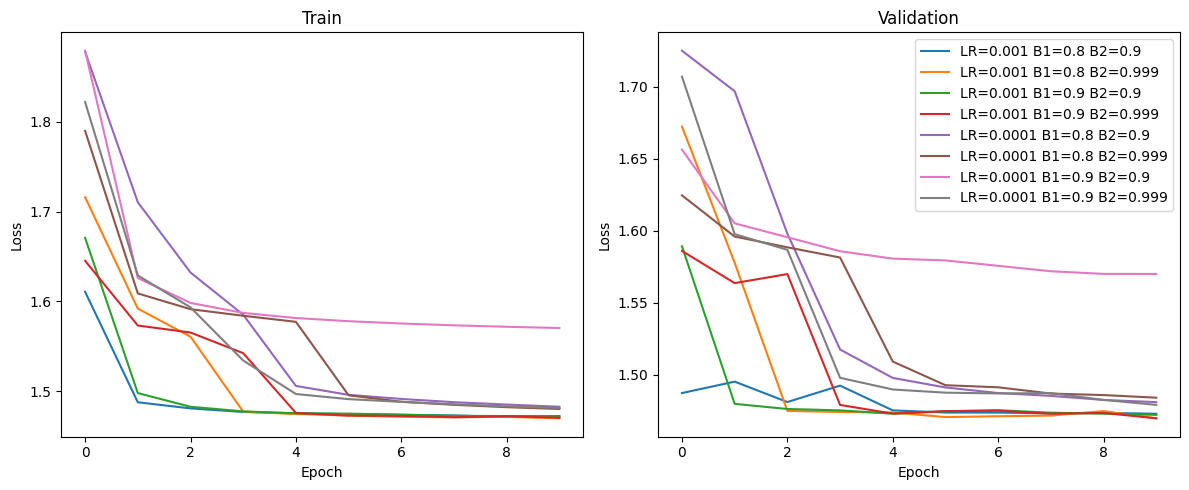

In [20]:
plot_by_hparams(MNIST_train_losses, MNIST_val_losses, "Loss", texts)

From the loss plots, we see that one model is lacking behind the other significantly. We also see that some hyper-parameters choices converged considerably faster than others. We noticed the biggest factor seem to be LR in our case, while B1 and B2 also have some impact.

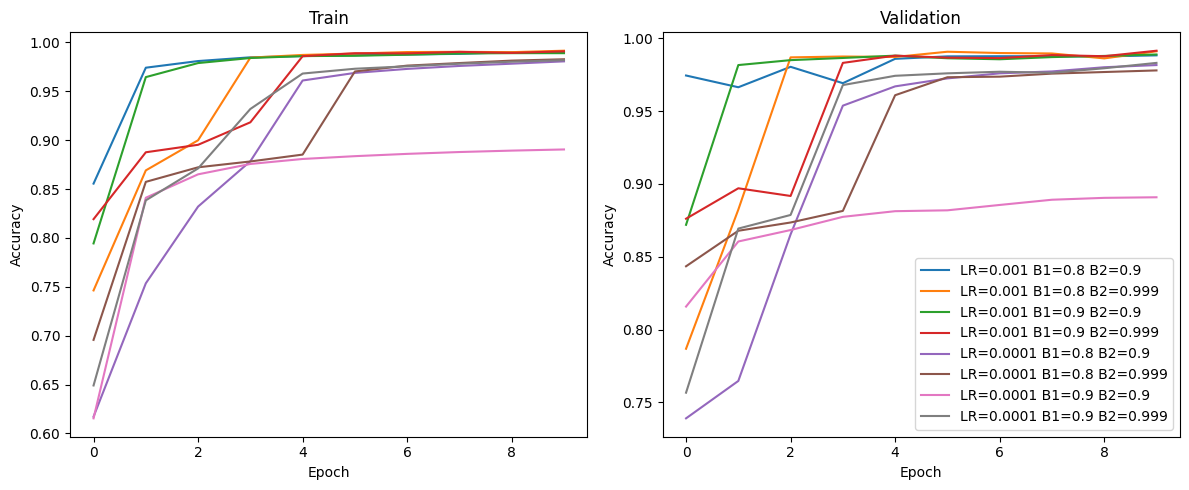

In [21]:
plot_by_hparams(MNIST_train_accs, MNIST_val_accs, "Accuracy", texts)

From the accuracy plots, we observe similar patterns as for the loss plots. Namely, models with LR=0.001 seem to converge faster and to the better accuracy values, while the best model uses the default and the most typical B1, B2 parameters.

However, we need to be mindful that the results might depend on a specific model architecture, and dataset used. MNIST classification is relatively simple task, thus, the differences between models might not be easily visible.

Finally, let us demonstrate the per-class accuracy of each model:

In [22]:
data = {}
for i in range( len(all_triplets) ):
    data[ f"LR={all_triplets[i][0]} B1={all_triplets[i][1]} B2={all_triplets[i][2]}" ] = per_class_accuracy(MNIST_models[i], MNIST_test_dataloader, 10)

df = pd.DataFrame(data)
df

,LR=0.001 B1=0.8 B2=0.9,LR=0.001 B1=0.8 B2=0.999,LR=0.001 B1=0.9 B2=0.9,LR=0.001 B1=0.9 B2=0.999,LR=0.0001 B1=0.8 B2=0.9,LR=0.0001 B1=0.8 B2=0.999,LR=0.0001 B1=0.9 B2=0.9,LR=0.0001 B1=0.9 B2=0.999
0,0.987755,0.995918,0.993878,0.993878,0.990816,0.990816,0.996939,0.995918
1,0.995595,0.997357,0.986784,0.997357,0.997357,0.998238,0.995595,0.997357
2,0.994186,0.987403,0.994186,0.996124,0.982558,0.965116,0.981589,0.973837
3,0.982178,0.994059,0.993069,0.994059,0.982178,0.968317,0.989109,0.988119
4,0.994908,0.987780,0.992872,0.996945,0.992872,0.996945,0.998982,0.991853
5,0.995516,0.987668,0.992152,0.987668,0.991031,0.994395,0.988789,0.991031
6,0.971816,0.990605,0.974948,0.980167,0.963466,0.975992,0.984342,0.965553
7,0.984436,0.979572,0.992218,0.990272,0.978599,0.991245,0.985409,0.987354
8,0.987680,0.995893,0.983573,0.991786,0.970226,0.935318,0.000000,0.973306
9,0.987116,0.993062,0.984143,0.984143,0.964321,0.960357,0.959366,0.964321


We observe that the worst model completely struggles with classification of digit '8'. Next, we see that the best model performs extremely well on all the digits (the mistakes it makes might be similar to ones discussed in the first exercise). Other than that, we observe similar patterns as in the exercise 1. Namely, the lowest accuracy is achieved for the digits that are very similar to other ones (like '6' and '9' for instance).